<h1 style= "text-align:center; color:white; background-color:black; font-size:40px;">Import Libraries</h1>

In [1]:
pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import tensorflow as tf
import keras_tuner as kt
import cv2
import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

2024-05-28 18:46:30.658923: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 18:46:30.659018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 18:46:30.826997: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<h1 style= "text-align:center; color:white; background-color:black; font-size:40px;">Setting Enviroment Variables</h1>

In [3]:
PATH_DIR = '/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification' #path dir with all the data base
IMG_SIZE = 256 # the final size of the image
BATCH_SIZE = 64 # number of batches
BUFFER_SIZE = 1000 # how much will be shuffle the ds
PATIENCE = 5 # the number of epochs without improvement before to change the configuration of the model

<h1 style= "text-align:center; color:white; background-color:black; font-size:40px;">Creating Pipeline To Load And Transform Data</h1>

In [4]:
class GetFiles():
    
    """The class GetFiles builds a pipeline to extract data from a file directory, 
    then transforms and standardizes the data into a numpy array in the range of [0-1]."""
        
    def __init__(self,
                 dir_path:str,
                 img_size:int,
                 batch_size:int)-> None:
        
        """ Receive the initial parameters to perform the pipelone

        Args:

            path_dir (str): The path with the images to use in test and train.
            img_size (int): The size of the image to reshape
            batch_size (int): The batch size for the data
            shuffle (bool) = False: If the data will be shuffle or not.

        Returns:
        
            None
        """
        
        self.dir_path = dir_path
        self.img_size = (img_size,img_size)
        self.batch_size = batch_size
    
    def get_files(self):
    
        """ Check each folder inside of a path and convert the path into tensorflow dataset

        Args:

            path_dir (str): The path with the images to use in the train
            img_size (int): The size of the image to reshape
            batch_size (int): The batch size for the data
            shuffle (bool) = False: If the data will be shuffle or not.

        Returns:

            self.train (_dataset_datasettensorflow.python.data.ops.prefetch_op._PrefetchDataset): A prefecth _PrefetchDataset who contains the image transformed into tensors
            self.test (_datasettensorflow.python.data.ops.prefetch_op._PrefetchDataset): A _PrefetchDataset who contains the image transformed into tensors

        """

        self.train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
            self.dir_path,
            image_size =self.img_size,
            batch_size = self.batch_size,
            subset="training",
            labels="inferred",
            label_mode="int",
            validation_split=0.1,
            shuffle=True,
            color_mode="rgb",
            seed=40
        )

        self.test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
            self.dir_path,
            image_size =self.img_size,
            batch_size = self.batch_size,
            subset="training",
            labels="inferred",
            label_mode="int",
            validation_split=0.1,
            shuffle=True,
            color_mode="rgb",
            seed=40
        )
    
    # Inspect class name
    
        return self.train_dataset, self.test_dataset
    
    def dict_label(self,train_ds)-> dict:
        
        """ Create a diccionary with the labels of the dataset

            Args:

                train_ds(_datasettensorflow.python.data.ops.prefetch_op._PrefetchDataset): _PrefectDataset to create the dict of labels

            Returns:

                class_names_dict (dict): Returns a dicctionary with the labels named
        """   
            
        self.class_names = train_ds.class_names
        class_names_dict = { key:values for key,values in enumerate(self.class_names)}
        
        return class_names_dict
    
    def preprocess(self,img):
        
        """ Prepare the data to cast

        Args:
        
            img(tensorflow.python.framework.ops.SymbolicTensor): The tensor that we want to cast into tf.float32 and and normalized the data
            
        Returns:

            tensorflow.python.framework.ops.SymbolicTensor: A symbolic tensor who contains the normalized images 
        """
            
        img = tf.cast(img, "float32") / 255.0
        return img

    def run_preprocess(self,train_ds,test_ds):
        """ Run the preprocess function using map to change the tensor type to float32 and normalize the data

        Args:
        
            train_ds(_datasettensorflow.python.data.ops.prefetch_op._PrefetchDataset): _PrefectDataset that contain the data without normalization 
            test_ds(_datasettensorflow.python.data.ops.prefetch_op._PrefetchDataset): _PrefectDataset that contain the data without normalization 
            
        Returns:

            self.train_dataset (_datasettensorflow.python.framework.ops.SymbolicTensor): A symbolic tensor who contains the normalized images 
            self.val (_datasettensorflow.python.framework.ops.SymbolicTensor): A symbolic tensor who contains the normalized images 
        """
        
        self.train_dataset = train_ds.map(lambda x, y: (self.preprocess(x), y))
        self.val_dataset = test_ds.map(lambda x, y: (self.preprocess(x), y))
        
        return self.train_dataset, self.val_dataset
    
    def transform_to_numpy_array(self,train_ds,test_ds):
        """ It transform the tensors into numpy arrays

        Args:
        
            train_ds(_datasettensorflow.python.data.ops.prefetch_op._PrefetchDataset): _PrefectDataset that contain data normalized 
            test_ds(_datasettensorflow.python.data.ops.prefetch_op._PrefetchDataset): _PrefectDataset that contain data normalized 
            
        Returns:

            x_train(np.ndarray): Numpy array that contain the images that will be use to train.
            y_train (np.ndarray): Numpy array that contain the labels that will be use to train.
            x_val (np.ndarray): Numpy array that contain the images that will be be use to test.
            y_val (np.ndarray): Numpy array that contain the labels that will be use to train.
        """

        NUM_CLASSES = len(self.class_names)
        x_train = []
        y_train = []
        x_val = []
        y_val = []

        for images, labels in train_ds:
            #append train data to x_train
            x_train.append(images.numpy())

            #append labels to y_train
            y_train.append(labels.numpy())

        # concatenate all the batches to get the full list
        x_train = np.concatenate(x_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)


        for images, labels in test_ds:
            #append train data to x_train
            x_val.append(images.numpy())

            #append labels to y_train
            y_val.append(labels.numpy())

        # concatenate all the batches to get the full list
        x_val = np.concatenate(x_val, axis=0)
        y_val = np.concatenate(y_val, axis=0)
        
        y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
        y_val = tf.keras.utils.to_categorical(y_val, NUM_CLASSES)

        return x_train,y_train,x_val,y_val
    
    def pipeline(self, return_dict:bool = True):
        """ Concatenate the previous functions (get_files,dict_label,preprocess,run_preprocess,transfot_to_numpy_array) sequentially to perform a pipeline

            Args:
            
                return_dict (bool): If it is True returns the label dict in the pipeline

                
            Returns:

                x_train (np.ndarray): Returns x_train
                y_train (np.ndarray): Returns y_train
                x_val (np.ndarray): Returns x_val
                y_val (np.ndarray): Returns y_val
                class_names_dict(dict): Returns the label dicciontary
        """   
        
        train_dataset, test_dataset = self.get_files()
        class_names_dict = self.dict_label(train_dataset)
        train_dataset, val_dataset = self.run_preprocess(train_dataset, test_dataset)
        x_train,y_train,x_val,y_val = self.transform_to_numpy_array(train_dataset, val_dataset)
        
        if return_dict:
            
            return x_train,y_train,x_val,y_val,class_names_dict
        else:
            return x_train,y_train,x_val,y_val
            
        
# Creating GetFiles instance     
file_loader = GetFiles(PATH_DIR, IMG_SIZE, BATCH_SIZE)
x_train,y_train,x_val,y_val,class_names_dict = file_loader.pipeline()



Found 1129 files belonging to 10 classes.
Using 1017 files for training.
Found 1129 files belonging to 10 classes.
Using 1017 files for training.


In [5]:
print(f'label dict:\n{class_names_dict}')


label dict:
{0: 'Avulsion fracture', 1: 'Comminuted fracture', 2: 'Fracture Dislocation', 3: 'Greenstick fracture', 4: 'Hairline Fracture', 5: 'Impacted fracture', 6: 'Longitudinal fracture', 7: 'Oblique fracture', 8: 'Pathological fracture', 9: 'Spiral Fracture'}


<h1 style= "text-align:center; color:white; background-color:black; font-size:40px;">Plot Functions Data</h1>

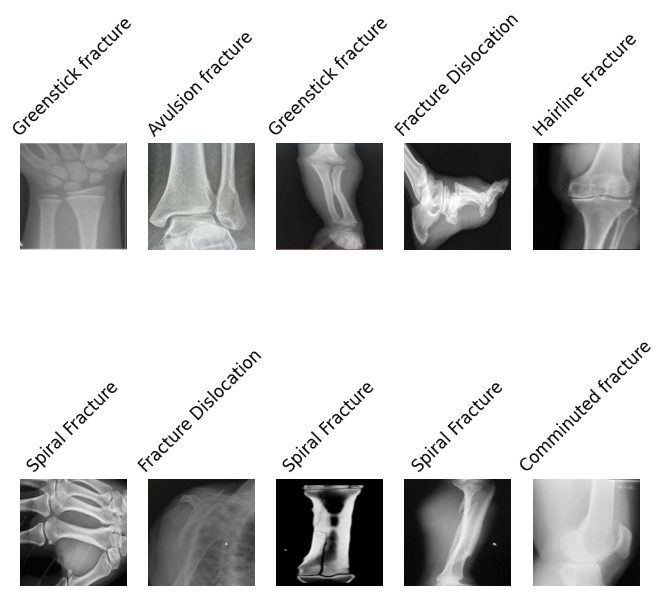

In [6]:
def display(images: np.ndarray,
            labels: np.ndarray,
            label_dict: dict, 
            n: int = 10, 
            size: tuple = (8, 8), 
            cmap: str = "gray_r") -> None:
    
    """ Plot n images from numpy.narray
    
    Args:
    
        images (np.ndarray): Numpy array that contains the images.
            labels (np.ndarray): Numpy arrays that contains the labels.
            label_dict (dict): Label dict.
            n: (int = 10): Integer to set the number of plots.
            size: (tuple = (10, 10)): Tuple that assign the height and width of the plot
            cmap: (str = "gray_r"): Scale of grays to plot the images. 
        
    
    Returns:
       None
    
    """
    # Randomly select 'n' indices from the images
    indices = np.random.choice(len(images), n, replace=False)
    
    # Set up the subplots
    fig, axes = plt.subplots(2, n // 2, figsize=size)

    # Plot each image with its corresponding label
    for i, index in enumerate(indices):
        ax = axes.flat[i]
        image = images[index]
        label_index = np.argmax(labels[index])
        categorical_label = label_dict[label_index]
        
        ax.imshow(image, cmap=cmap)
        ax.set_title(categorical_label,rotation = 45)
        ax.axis('off')

    plt.show()

# Example usage
# x_train and y_train should be defined elsewhere in your code
# class_names_dict should be defined as a dictionary mapping label indices to label names
display(x_train[:500], y_train[:500], class_names_dict)


<h1 style= "text-align:center; color:white; background-color:black; font-size:40px;">Data Auguntation</h1>

<p>In this code I included a pipeline for data auguntatio but due the nature of the data it wasn't worth to use the pipepline</p>

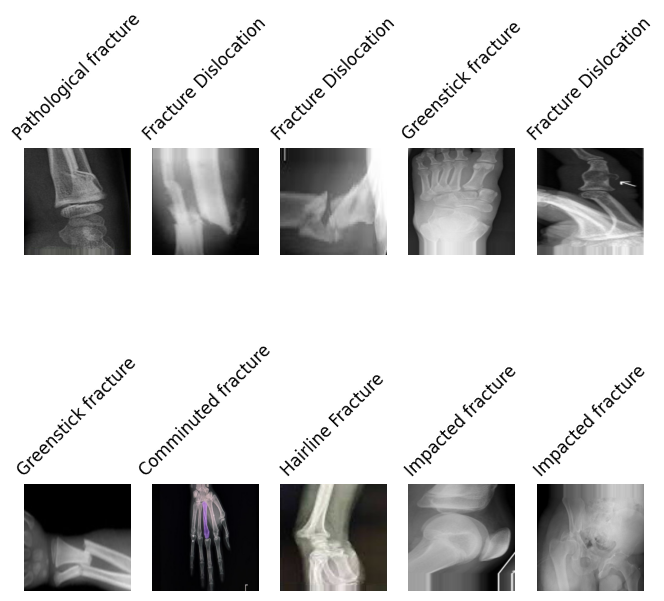

In [7]:
class DataPipelineWithAugmentation():
    """DataPipelineWithAugmentation create a pipeline to perform data auguntation"""
    
    def __init__(self, x_train:np.ndarray):
        self.x_train  = x_train
        """ Receive X_train as numpy.ndarray
    
    Args:
    
        self.x_train(np.ndarray): Numpy array
    
    Returns:
    
       None
        """
        
    def create_datage(self) -> keras.src.legacy.preprocessing.image.NumpyArrayIterator:
        """Transform the data by flipping the matrix both horizontally and vertically, as well as randomly shifting the image to the left or right.
    
    Args:
    
        None
    
    Returns:
       image(keras.src.legacy.preprocessing.image.NumpyArrayIterator): Returns a batched matrix with the transformations
        """
        self.datagen = ImageDataGenerator(
            horizontal_flip = True,
            vertical_flip = True,
            width_shift_range=0.2)
        
        image = self.datagen.flow(self.x_train)
        return image


ag = DataPipelineWithAugmentation(x_train)
x_train_ag=ag.create_datage()

# plot data auguntated
for image in x_train_ag:
    display(image,y_train,class_names_dict)
    break

<h1 style= "text-align:center; color:white; background-color:black; font-size:40px;">Creating model</h1>

In [8]:
def build_model():
    
    """ It is the main contructor of the  CNN model
    
    Args:
    
        None
    
    Returns:
    
       model2 (models.Model): Returns a built model
        """

    input_layer = layers.Input(shape=(256,256, 3))

    x = layers.Conv2D(
        filters=32,
        kernel_size=(3,3),
        strides=2,
        padding="same"
    )(input_layer)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(rate=0.2)(x)

    x = layers.Conv2D(
        64,
        3,
        strides=2,
        padding="same"
    )(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(rate=0.2)(x)

    x = layers.Conv2D(
        128,
        3,
        strides=2,
        padding="same"
    )(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(rate=0.2)(x)

    x = layers.Conv2D(
        256,
        3,
        strides=2,
        padding="same"
    )(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(rate=0.2)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(units=100)(x)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(rate=0.2)(x)

    output_layer = layers.Dense(units=10, activation="softmax")(x)


    model2 = models.Model(input_layer, output_layer)

    model2.summary()
    
    return model2
model2 = build_model()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     6,553,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,945,446 (26.49 MB)

 Trainable params: 6,944,286 (26.49 MB)

 Non-trainable params: 1,160 (4.53 KB)

In [9]:
    """ Here we setup the necessary information to perform the training """
    
opt = Adam(learning_rate=0.0005)
model2.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

"""Creating model Checkpoints to get the best model during training"""
model_checkpoint_callback = ModelCheckpoint(
    filepath="/kaggle/working/BestCNNModel_pt.keras",
    save_weights_only = False,
    save_freq = "epoch",
    monitor = "loss",
    mode = "min",
    save_best_only = True,
    verbose = 0
)

""" Setting up the training"""
history = model2.fit(
    x_train,
    y_train,
    shuffle=True,
    batch_size=32,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[
        model_checkpoint_callback]
)

Epoch 1/10
 3/32 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.1181 - loss: 2.8771

I0000 00:00:1716922032.151669      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716922032.174478      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.1449 - loss: 2.8013

W0000 00:00:1716922054.483327      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 768ms/step - accuracy: 0.1450 - loss: 2.7976 - val_accuracy: 0.2183 - val_loss: 2.2149
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.3011 - loss: 2.0210 - val_accuracy: 0.3481 - val_loss: 1.8606
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.4951 - loss: 1.5390 - val_accuracy: 0.6490 - val_loss: 1.1466
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.7122 - loss: 0.9738 - val_accuracy: 0.8220 - val_loss: 0.6143
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.8722 - loss: 0.5432 - val_accuracy: 0.9764 - val_loss: 0.2202
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9575 - loss: 0.3136 - val_accuracy: 0.9921 - val_loss: 0.1258
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9714 - loss: 0.2092 - val_accuracy: 0.9931 - val_loss: 0.0657
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9941 - loss: 0.1282 - val_accuracy: 0.9951 - val_loss: 

In [10]:
def evaluate_and_save_model(model, x_val,y_val):
    """ Evaluate the model and save on kaggle folder
    
    Args:
    
        model(models.Model): Model to evaluate.
        x_val(np.ndarray): Numpy array that represents the x_val.
        y_val(np.ndarray): Numpy array that represents the y_val.
    
    Returns:
    
       None
        """
    model.evaluate(x_val, y_val)
    tf.keras.models.save_model(model,'/kaggle/working/cnn_last_try.keras')
    
evaluate_and_save_model(model2, x_val,y_val)    

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9921 - loss: 0.0290
